# Классификация ответов

Изучим применение косинусного расстояния для классификации ответов по профессиям. 

У нас есть данные с признаками ответов, позволяющие выделить не относящиеся к профессиям. Есть нормализованные токены. И есть справочник профессий, также содержащий нормализованные токены.

- Выделим ответы, относящиеся только к профессиям;
- Загрузим справочник профессий;
- Оценим, какое количество профессий можно классфицировать сравнением строк нормализовнных токенов;
- Для профессий, которые не получилось классифицировать сравнением, применим поиск подходящей профессии по косинусному сходству:
    - преобразуем все нормализованные профессии из справоничка в вектора;
    - для каждого нормализованного ответа найдм профессию с максимальным сходством;
    - проанализируем результаты.

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

In [2]:
from gensim.models import fasttext

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Функции

In [6]:
def sentence_2_vec(model: fasttext.FastTextKeyedVectors, sentence: list) -> np.array:
    '''Преобразует предложение как массив слов в вектор как сумму векторов каждого слова
    '''
    vectors = [model.get_vector(word) for word in sentence]

    return np.sum(vectors, axis=0)

## Загрузка данных

In [7]:
answers = pd.read_csv('../datasets/intermediate/df_answers_analysed.csv', low_memory=False)
professions = pd.read_csv('../datasets/external/tokens-professions.csv')

In [8]:
answers.shape

(149700, 142)

In [9]:
professions.shape

(194, 2)

Выделим из ответов только относящиеся к профессиям и признаки, содержащие ответ и его признаки.

In [10]:
columns = ['q61', 'corrected', 'tokenized', 'normalized']

In [11]:
answers = answers.loc[
    ~answers.normalized.isna()\
    & (answers.n_verbs == 0)\
    & (answers.has_negative == 0)\
    & (answers.has_past_future == 0)\
    & (answers.n_out_of_vocab < 4), 
    columns]

In [12]:
answers.shape

(79548, 4)

In [13]:
answers.head()

,q61,corrected,tokenized,normalized
0,экономист,экономист,экономист,экономист
2,Учитель,учитель,учитель,учитель
6,рекламист,рекламы,рекламы,реклама
7,Руководитель участка,руководитель участка,руководитель участка,руководитель
11,Повар,повар,повар,повар


In [14]:
professions.head()

,prof_tokens,prof_names
0,автомойщик,автомойщик
1,автослесарь,автослесарь
2,автомеханик,автомеханик
3,мастер-приёмщик,мастер-приемщик
4,продажа,менеджер по продажам


## Прямое сравнение

In [15]:
answers['score'] = 0
answers['matched_token'] = None

In [16]:
prof_keys = professions.prof_tokens.to_list()
answers['direct_match'] = answers.apply(lambda row: 1 if row.normalized in prof_keys else 0, axis=1)

In [17]:
answers.direct_match.value_counts()

0    45747
1    33801
Name: direct_match, dtype: int64

In [18]:
answers[answers.direct_match == 1].head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match
0,экономист,экономист,экономист,экономист,0,None,1
2,Учитель,учитель,учитель,учитель,0,None,1
11,Повар,повар,повар,повар,0,None,1
17,Видеооператор,видеооператор,видеооператор,видеооператор,0,None,1
18,преподаватель,преподаватель,преподаватель,преподаватель,0,None,1


In [19]:
answers[answers.direct_match == 0].head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match
6,рекламист,рекламы,рекламы,реклама,0,None,0
7,Руководитель участка,руководитель участка,руководитель участка,руководитель,0,None,0
12,Фитнес,фитнес,фитнес,фитнес,0,None,0
15,Менеджер регионального отдела продаж,менеджер регионального отдела продаж,менеджер регионального отдела продаж,продажа региональный,0,None,0
16,инженер,инженер,инженер,инженер,0,None,0


In [20]:
answers.loc[answers.direct_match == 1, 'score'] = 1
answers.loc[answers.direct_match == 1, 'matched_token'] = answers.loc[answers.direct_match == 1, 'normalized'] 

## Сопоставление по косинусному сходству

Загрузим модель для векторизации токенов.

In [21]:
cc_ru_path = '../models/cc_ru_300_kv/cc_ru_300.kv'
model = fasttext.FastTextKeyedVectors.load(cc_ru_path)

Получим вектора для токенов профессий.

In [22]:
v_professions = []
for prof in prof_keys:
    words = prof.split()
    v = sentence_2_vec(model=model, sentence=words)
    v_professions.append(v)

In [23]:
unmatched = answers[answers.direct_match == 0]
unmatched.shape

(45747, 7)

In [24]:
def find_similar(what: np.array, where: list) -> tuple:
    '''Ищет вектор в where с максимальным косинусным сходством с what 
    '''
    matrix = pd.DataFrame(cosine_similarity([what], where)).T
    idx = matrix.idxmax()
    score = matrix.max().item()

    return idx, score

In [25]:
for i, row in tqdm(unmatched.iterrows(), total=unmatched.shape[0]):
    v = sentence_2_vec(model=model, sentence=row.normalized.split())
    idx, score = find_similar(what=v, where=v_professions)
    matched_token = professions.prof_tokens[idx].item()
    answers.loc[i, 'score'] = score
    answers.loc[i, 'matched_token'] = matched_token

100%|██████████| 45747/45747 [03:08<00:00, 243.28it/s]


In [26]:
columns = columns + ['direct_match', 'score', 'matched_token']

In [27]:
answers[answers.direct_match == 1][columns].sample(10)

,q61,corrected,tokenized,normalized,direct_match,score,matched_token
110168,Менеджер по продажам,менеджер по продажам,менеджер по продажам,продажа,1,1.0,продажа
84615,Психолог,психолог,психолог,психолог,1,1.0,психолог
24947,Повар,повар,повар,повар,1,1.0,повар
66614,Военнослужащий,военнослужащий,военнослужащий,военнослужащий,1,1.0,военнослужащий
30572,Курьер,курьер,курьер,курьер,1,1.0,курьер
3598,программист,программист,программист,программист,1,1.0,программист
132452,учитель,учитель,учитель,учитель,1,1.0,учитель
137551,Персонал и обучение | HR-менеджер,менеджер персонала,менеджер персонала,персонал,1,1.0,персонал
123245,Психолог,психолог,психолог,психолог,1,1.0,психолог
85630,Художником,художником,художником,художник,1,1.0,художник


<AxesSubplot:>

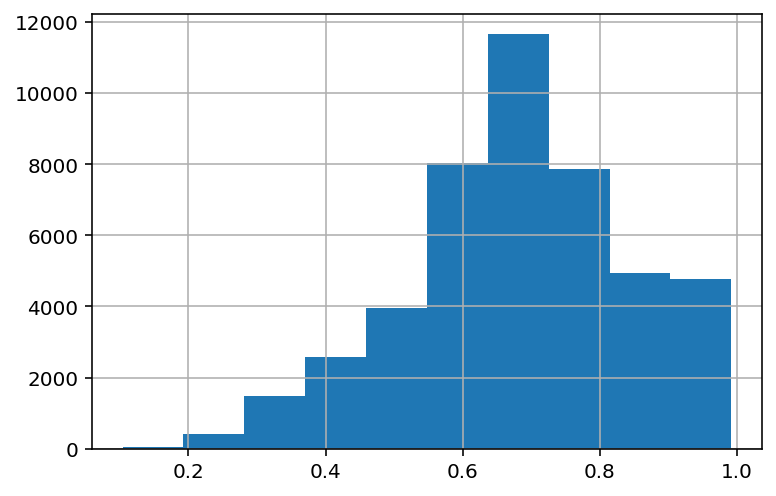

In [28]:
answers[answers.direct_match == 0].score.hist(bins=10)

In [29]:
answers[(answers.direct_match == 0)][columns].sample(10)

,q61,corrected,tokenized,normalized,direct_match,score,matched_token
145576,Администрирование | Секретарь-референт,секретарь-референт,секретарь-референт,секретарь-референт,0,0.678314,офис-менеджер
109833,танцор,танцор,танцор,танцор,0,0.635488,артист
97238,Костиком,мостиком,мостиком,мостик,0,0.362631,контактный специалист центр
19181,"Специалист по туризму, переводчик",специалист по туризму переводчик,специалист по туризму переводчик,переводчик специалист туризм,0,0.804688,туризм
31652,Государственный лесной инспектор,государственный лесной инспектор,государственный лесной инспектор,государственный инспектор лесной,0,0.575128,инженер сетевой
90101,химик,химик,химик,химик,0,0.647603,геолог
124667,методист,методист,методист,методист,0,0.710220,педагог
32564,предприниматель,предприниматель,предприниматель,предприниматель,0,0.587094,юрист
34869,идиотом,идиотом,идиотом,идиот,0,0.410286,охранник
102271,экспедитор,экспедитор,экспедитор,экспедитор,0,0.675851,грузчик


Сохраним полученные соответствия для анализа и создания обучабщи выборок.

In [30]:
matched = answers.merge(professions, 
                        how='left', 
                        left_on='matched_token', 
                        right_on='prof_tokens').drop('prof_tokens', axis=1)
matched.head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match,prof_names
0,экономист,экономист,экономист,экономист,1.000000,экономист,1,экономист
1,Учитель,учитель,учитель,учитель,1.000000,учитель,1,учитель
2,рекламист,рекламы,рекламы,реклама,0.911108,маркетинг реклама,0,менеджер по маркетингу и рекламе
3,Руководитель участка,руководитель участка,руководитель участка,руководитель,0.809574,директор исполнительный,0,исполнительный директор
4,Повар,повар,повар,повар,1.000000,повар,1,повар


In [31]:
matched.to_csv('../datasets/processed/answer-profession-match.csv', index=False)

### Анализ результатов

In [32]:
answers.loc[answers.score < .85, 'matched_token'] = answers.loc[answers.score < .9, 'normalized']
answers.loc[answers.score < .85, 'prof_names'] = answers.loc[answers.score < .9, 'normalized']

In [33]:
print('Прямых совпадений', matched[matched.direct_match == 1].shape[0])
print('Cоответствий справочнику со score [0.85, 1.0]', matched[(matched.direct_match == 0)\
                                                             & (matched.score >= .85)].shape[0])
print('Cоответствий справочнику со score (0.6, 0.85)', matched[(matched.direct_match == 0)\
                                                             & (matched.score.between(.6,.85))].shape[0])
print('Cоответствий справочнику со score [0, 0.6]', matched[(matched.direct_match == 0)\
                                                             & (matched.score <= .6)].shape[0])
print('Всего ответов с профессиями: ', answers.shape[0])


Прямых совпадений 33801
Cоответствий справочнику со score [0.85, 1.0] 7526
Cоответствий справочнику со score (0.6, 0.85) 24498
Cоответствий справочнику со score [0, 0.6] 13723
Всего ответов с профессиями:  79548


In [34]:
source_distribution = answers.q61.str.lower().value_counts().reset_index()
normailized_ditribution = answers.normalized.value_counts().reset_index()
matched_ditribution = answers.matched_token.value_counts().reset_index()
limit = matched.matched_token.value_counts().reset_index()


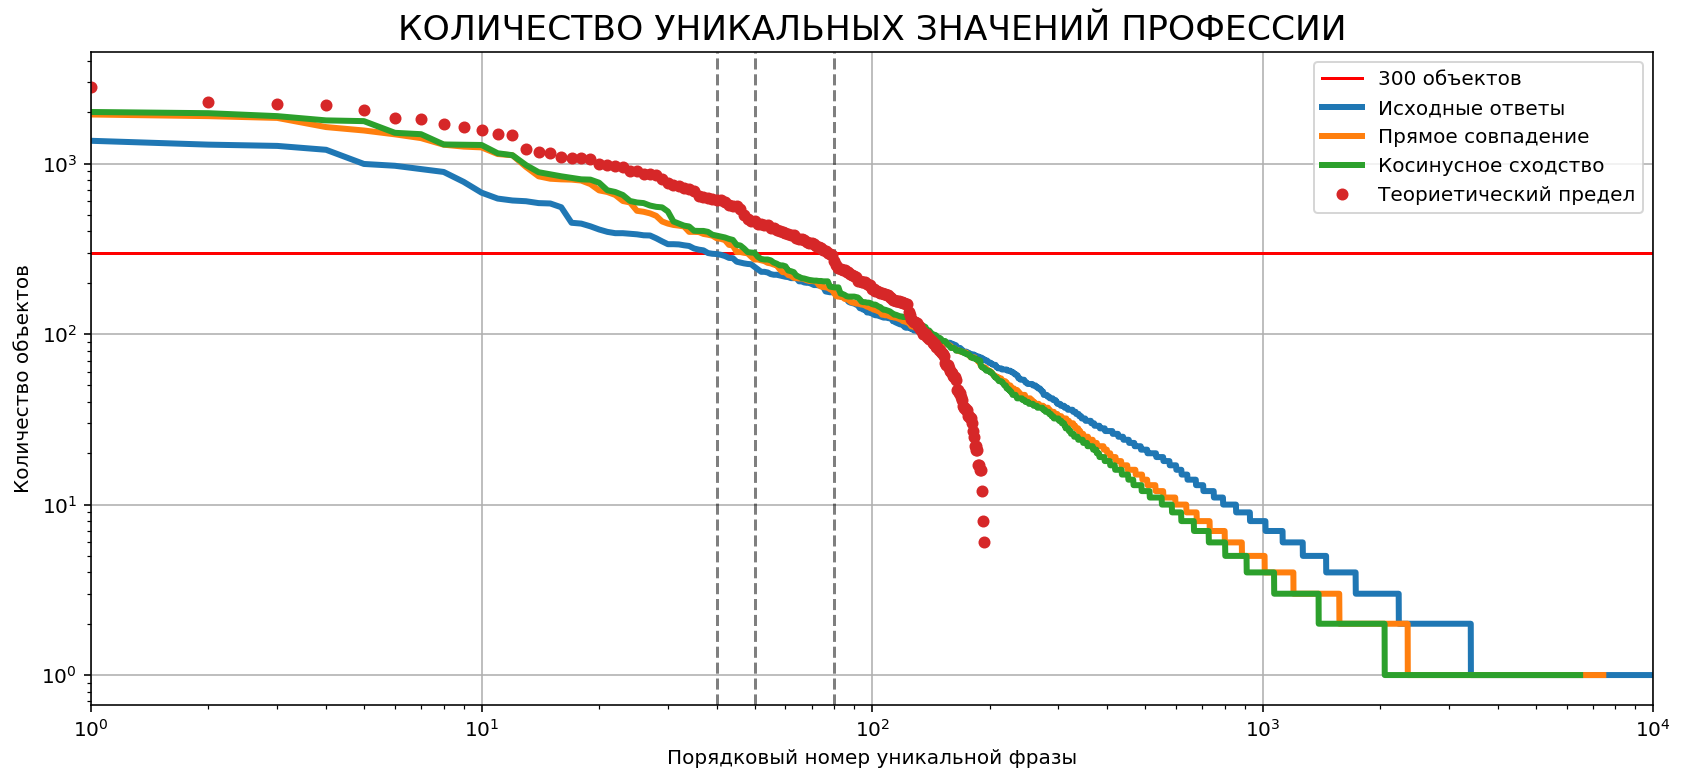

In [41]:
plt.figure(figsize=(14,6))
plt.yscale('log')
plt.xscale('log')
plt.axhline(300, c='r', label='300 объектов')
plt.axvline(40, c='k', alpha=.5, ls='--')
plt.axvline(50, c='k', alpha=.5, ls='--')
plt.axvline(80, c='k', alpha=.5, ls='--')
plt.plot(source_distribution.index, source_distribution['q61'], label='Исходные ответы', lw=3)
plt.plot(normailized_ditribution.index, normailized_ditribution['normalized'], label='Прямое совпадение', lw=3)
plt.plot(matched_ditribution.index, matched_ditribution['matched_token'], label='Косинусное сходство', lw=3)
plt.plot(limit.index, limit['matched_token'], label='Теориетический предел', lw=0, marker='o', markersize=5)
plt.ylabel('Количество объектов')
plt.xlabel('Порядковый номер уникальной фразы')
plt.title('Количество уникальных значений профессии'.upper(), fontsize='xx-large')
plt.legend()
plt.grid(visible=True)
plt.xlim(1, 1e4)
plt.savefig('../reports/answers_matching.png', dpi=300, transparent=False)
plt.show()

## Вывод

Мы видим, что в оригинальном датасете 40 уникальных значений, относящихся к профессия, встречались в 300+ анкетах. 

Приведение ответов и значений справочника профессий к нормальной форме позволило классифицировать чуть менее половины ответов простым сравнением строк. Это решение увеличило количество профессий с числом анкет 300+ до 50 и дало существенный прирост в количестве анкет на профессию по отношению к оригинальному датасету.

Поиск соответствия по косинусной схожести с порогом >.85 позволил классифицировать ответы еще 7500 анкет, что стало незначительным улучшением прямого сравнения. 

Отметим, что в идеальном случае (предположим, что все сопоставления являются правильными) применение мульти-классовой классификации ответов на исследуемом датасете позволяет вдвое увеличить количество профессий с количеством анкет 300+. Что говорит о перспективности работы в этом направлении.